# Часть 1

# Определение количества занятых мест на парковке

In [121]:
import pandas as pd
import os
import cv2
import torchvision
import torch
from PIL import Image

Будем использовать предобученную модель fastercnn

In [122]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [123]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [124]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [125]:
data = pd.read_csv('/content/gdrive/MyDrive/Practice_AAM/CNRPark+EXT.csv')

<ipython-input-125-7ee4fd04025b>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/gdrive/MyDrive/Practice_AAM/CNRPark+EXT.csv')


In [126]:
data.head()

,camera,datetime,day,hour,image_url,minute,month,occupancy,slot_id,weather,year,occupant_changed
0,A,20150703_0805,3,8,CNRPark/A/free/20150703_0805_1.jpg,5,7,0,1,S,2015,NaN
1,A,20150703_0810,3,8,CNRPark/A/free/20150703_0810_1.jpg,10,7,0,1,S,2015,NaN
2,A,20150703_0815,3,8,CNRPark/A/busy/20150703_0815_1.jpg,15,7,1,1,S,2015,0.0
3,A,20150703_0820,3,8,CNRPark/A/busy/20150703_0820_1.jpg,20,7,1,1,S,2015,0.0
4,A,20150703_0825,3,8,CNRPark/A/busy/20150703_0825_1.jpg,25,7,1,1,S,2015,0.0


Проверим сколько разных папок содержат данные

In [127]:
mas = []

def check(x):
  global mas
  if x[:5] in mas:
    return x
  else:
    mas.append(x[:5])
    return x

In [128]:
data['image_url'].apply(lambda x: check(x))

0                        CNRPark/A/free/20150703_0805_1.jpg
1                        CNRPark/A/free/20150703_0810_1.jpg
2                        CNRPark/A/busy/20150703_0815_1.jpg
3                        CNRPark/A/busy/20150703_0820_1.jpg
4                        CNRPark/A/busy/20150703_0825_1.jpg
                                ...                        
157544    CNR-EXT/PATCHES/RAINY/2016-02-12/camera9/R_201...
157545    CNR-EXT/PATCHES/RAINY/2016-02-12/camera9/R_201...
157546    CNR-EXT/PATCHES/RAINY/2016-02-12/camera9/R_201...
157547    CNR-EXT/PATCHES/RAINY/2016-02-12/camera9/R_201...
157548    CNR-EXT/PATCHES/RAINY/2016-02-12/camera9/R_201...
Name: image_url, Length: 157549, dtype: object

Всего 2, нам нужна вторая

In [129]:
mas

['CNRPa', 'CNR-E']

Изменим путь файла на правильный

In [130]:
data.loc[150000, 'image_url']

'CNR-EXT/PATCHES/SUNNY/2016-01-18/camera8/S_2016-01-18_08.14_C08_324.jpg'

In [131]:
def change_path(x):
  if x[:5] == 'CNR-E':
    return x[16:]
  return x

In [132]:
data['image_url'] = data['image_url'].apply(lambda x: change_path(x))

In [133]:
data.loc[90071, 'image_url']

'OVERCAST/2015-12-19/camera4/O_2015-12-19_08.51_C04_225.jpg'

In [134]:
def preprocessing(x):
  t = 0
  cnt = 0
  ans = ''
  for symb in x:
    if symb == '/':
      t += 1
    if t == 3:
      ans = ans + x[:cnt+1]
      break
    cnt += 1

  ans = ans + x[cnt+3:cnt+16]
  ans = ans + x[cnt+17:cnt+19]
  return ans + '.jpg'

In [135]:
data['image_url'] = data['image_url'].apply(lambda x: preprocessing(x))

In [136]:
data.loc[90071, 'image_url']

'OVERCAST/2015-12-19/camera4/2015-12-19_0851.jpg'

In [137]:
path = '/content/gdrive/MyDrive/Practice_AAM/FULL_IMAGE_1000x750'

Теперь для удобства из данного датасета "возьмем" только необходимые данные

In [138]:
idx = 0
for i, x in enumerate(data['image_url']):
  if x[:5] != 'CNRPa':
    idx = i
    break
print(idx)

12584


In [139]:
df = data.iloc[12584:, :]

In [140]:
df.head()

,camera,datetime,day,hour,image_url,minute,month,occupancy,slot_id,weather,year,occupant_changed
12584,01,2015-11-12_07.09,12,7,SUNNY/2015-11-12/camera1/2015-11-12_0709.jpg,9,11,0,184,S,2015,NaN
12585,02,2015-11-12_07.14,12,7,SUNNY/2015-11-12/camera2/2015-11-12_0714.jpg,14,11,0,184,S,2015,NaN
12586,01,2015-11-12_07.39,12,7,SUNNY/2015-11-12/camera1/2015-11-12_0739.jpg,39,11,0,184,S,2015,NaN
12587,02,2015-11-12_07.44,12,7,SUNNY/2015-11-12/camera2/2015-11-12_0744.jpg,44,11,0,184,S,2015,NaN
12588,01,2015-11-12_08.09,12,8,SUNNY/2015-11-12/camera1/2015-11-12_0809.jpg,9,11,0,184,S,2015,NaN


Откроем одно из изображений и подадим на вход модели

In [141]:
df.iloc[1, 4]

'SUNNY/2015-11-12/camera2/2015-11-12_0714.jpg'

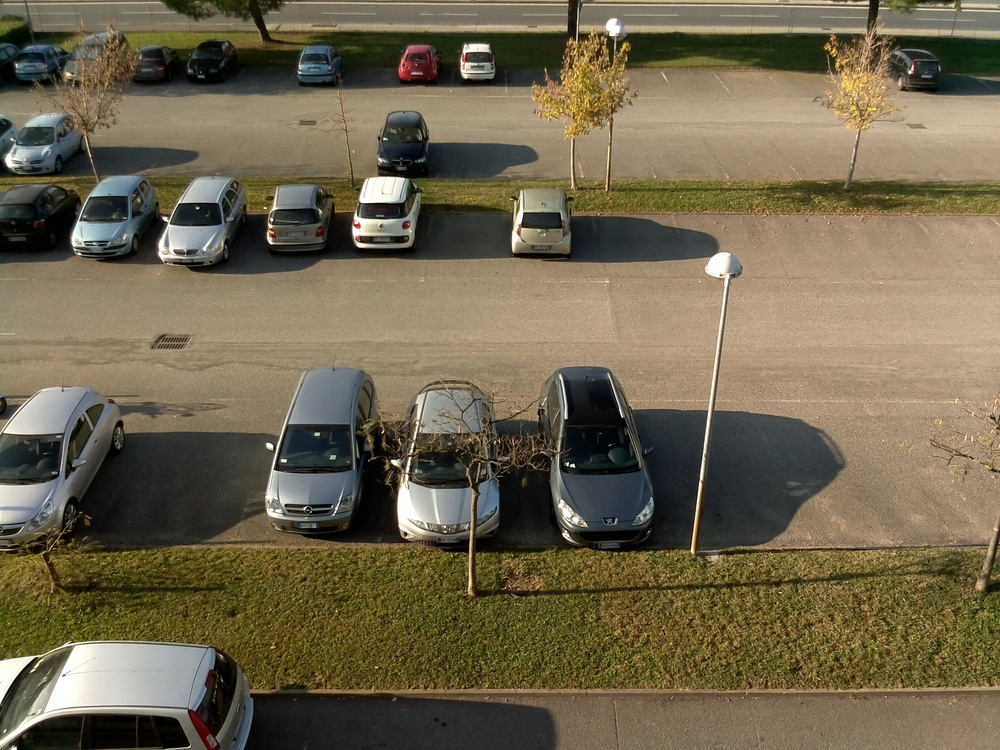

In [173]:
img = Image.open(f'{path}/{df.iloc[1000, 4]}')
img

In [174]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
pic = transform(img)

In [144]:
pred = model([pic])

In [145]:
pred

[{'boxes': tensor([[2.9535e+02, 4.4760e+01, 3.4417e+02, 8.6495e+01],
          [6.9081e+01, 1.7752e+02, 1.6468e+02, 2.6022e+02],
          [1.6757e+00, 1.1259e+02, 8.7175e+01, 1.7531e+02],
          [0.0000e+00, 1.8268e+02, 7.9507e+01, 2.5068e+02],
          [2.6368e+02, 1.8082e+02, 3.3608e+02, 2.5339e+02],
          [2.0028e+00, 6.4020e+02, 2.6175e+02, 7.4659e+02],
          [1.8544e+02, 3.9495e+01, 2.3871e+02, 8.2544e+01],
          [3.9705e+02, 4.4841e+01, 4.3917e+02, 8.4793e+01],
          [3.5068e+02, 1.7439e+02, 4.2317e+02, 2.5082e+02],
          [4.5782e+02, 4.5061e+01, 4.9630e+02, 8.1311e+01],
          [1.3372e+02, 4.4944e+01, 1.8002e+02, 8.2906e+01],
          [3.8775e+02, 3.7739e+02, 5.1144e+02, 5.4269e+02],
          [8.8752e+02, 4.6126e+01, 9.4416e+02, 9.1039e+01],
          [1.5795e+02, 1.7310e+02, 2.4769e+02, 2.6746e+02],
          [3.7511e+02, 1.1038e+02, 4.3026e+02, 1.7637e+02],
          [1.3414e+01, 4.4866e+01, 6.6666e+01, 8.4933e+01],
          [5.0967e+02, 1.8765e+

Обработаем вывод данных

Будем брать метки = 3, т.к. это метка машины (занятое место являетя то, на котором припаркована машина). Также будем брать только те боксы, у которых "уверенность" предсказания модели выше 0.5

In [175]:
treshold = 0.35
ind = 0

for i, elem in enumerate(pred[0]['scores'].detach()):
  if elem < treshold:
    ind = i
    break

label = pred[0]['labels'][:ind].detach()

In [176]:
label

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 8, 3, 3, 8, 8,
        8, 3, 1])

выделим координаты bound-box (x1, y1), (x2, y2)

In [177]:
boxes = []

for i, elem in enumerate(pred[0]['boxes'].detach()):
  if i >= ind:
    break
  if label[i] == 3:
    boxes.append([(int(elem[0]), int(elem[1])), (int(elem[2]), int(elem[3]))])

boxes[0]

[(295, 44), (344, 86)]

In [178]:
boxes

[[(295, 44), (344, 86)],
 [(69, 177), (164, 260)],
 [(1, 112), (87, 175)],
 [(0, 182), (79, 250)],
 [(263, 180), (336, 253)],
 [(2, 640), (261, 746)],
 [(185, 39), (238, 82)],
 [(397, 44), (439, 84)],
 [(350, 174), (423, 250)],
 [(457, 45), (496, 81)],
 [(133, 44), (180, 82)],
 [(887, 46), (944, 91)],
 [(157, 173), (247, 267)],
 [(375, 110), (430, 176)],
 [(13, 44), (66, 84)],
 [(509, 187), (572, 256)],
 [(0, 43), (19, 84)],
 [(260, 366), (386, 536)],
 [(0, 114), (16, 165)],
 [(1, 378), (127, 553)],
 [(535, 365), (658, 547)]]

выделим объекты в прямоугольники

In [179]:
for k in range(len(boxes)):
  for i in range(pic.shape[1]):
    for j in range(pic.shape[2]):
      if i > boxes[k][0][0] and i < boxes[k][1][0] and (j == boxes[k][0][1] or j == boxes[k][1][1]):
        pic[0][j][i] = 0.8
        pic[1][j][i] = 0
        pic[2][j][i] = 0
      elif (i == boxes[k][0][0] or i == boxes[k][1][0]) and j > boxes[k][0][1] and j < boxes[k][1][1]:
        pic[0][j][i] = 0.8
        pic[1][j][i] = 0
        pic[2][j][i] = 0


Выведем кол-во занятых мест и фото

In [180]:
print(f"Количество занятых мест = {sum(label==3)}")

Количество занятых мест = 21


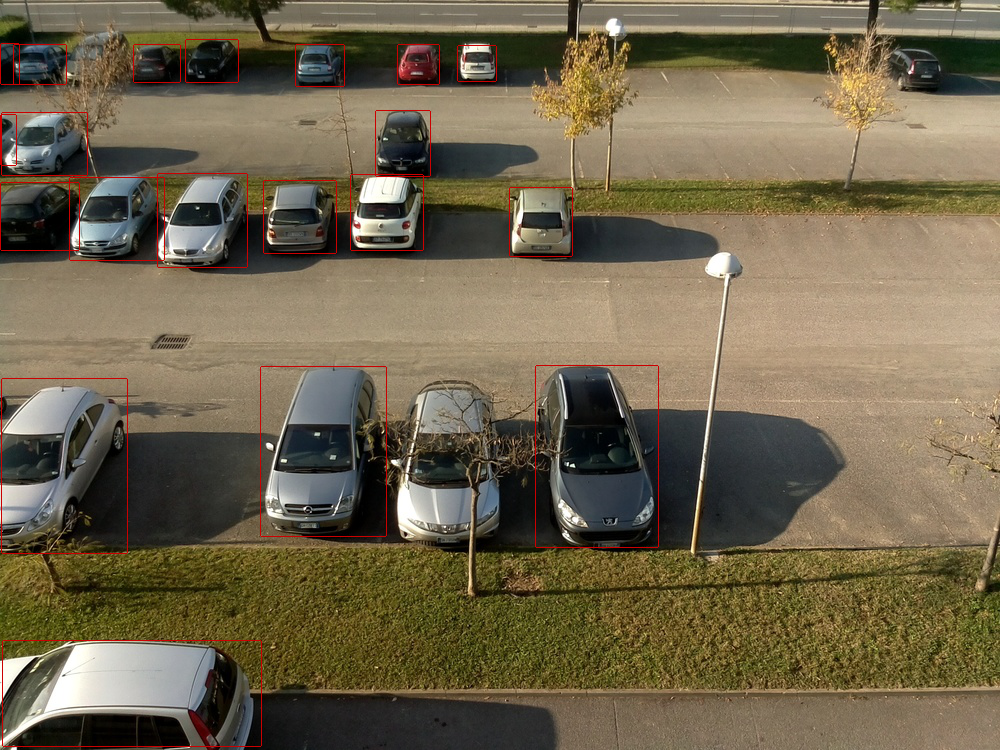

In [181]:
to_img = torchvision.transforms.ToPILImage()
img = to_img(pic)
img